In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact
import joblib
import shap
shap.initjs()
import warnings
import lightgbm as lgb
import pickle
# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
import MyClassAndFun as MCF

In [2]:
df=pd.read_csv('transformed__dumm_train.csv')
df.drop(['id','customer_id','month','ssn_aaa','monthly_inhand_salary','delay_from_due_date'], axis=1, inplace=True)#,
       #  'num_credit_card','interest_rate'], axis=1, inplace=True)
X=df.drop('credit_score', axis=1)
y=df['credit_score']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=1,stratify=y)
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
transform_var_list=['age','annual_income','changed_credit_limit',#'delay_from_due_date',,'interest_rate'
                    'credit_utilization_ratio','credit_history_monts',#'outstanding_debt',
                    'num_of_delayed_payment','total_emi_per_month','amount_invested_monthly','monthly_balance',]
for i in transform_var_list:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.transform(X_test[[i]])
X_train_df=pd.DataFrame(X_train,columns=X.columns)
X_test_df=pd.DataFrame(X_test,columns=X.columns)
combined_df = pd.concat([X_train_df, y_train], axis=1)
test_results = MCF.perform_tests(combined_df)
# print(test_results.sort_values(by="t-statistic", ascending=False))
X_test_df=X_test_df[list(test_results.loc[test_results['p-value']==0].column)]
X_train_df=X_train_df[list(test_results.loc[test_results['p-value']==0].column)]


In [3]:
# Random_Forest_C=RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
#                         n_estimators=800)
# Random_Forest_C.set_params(random_state=42, n_jobs = -1)
# Random_Forest_C.fit(X_train_df, y_train)
# Saving model
# joblib.dump(Random_Forest_C, 'random_forest_model.joblib')

# Loading the model back
Random_Forest_C = joblib.load('random_forest_model.joblib')

Random_Forest_pred = Random_Forest_C.predict(X_test_df)

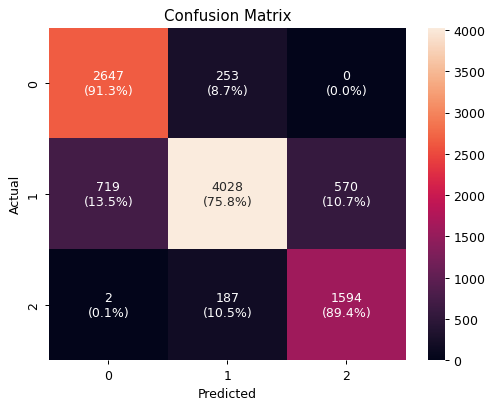

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      2900
           1       0.90      0.76      0.82      5317
           2       0.74      0.89      0.81      1783

    accuracy                           0.83     10000
   macro avg       0.81      0.85      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [4]:
Random_Forest_pred = Random_Forest_C.predict(X_test_df)
confusion = confusion_matrix(y_test, Random_Forest_pred)
report = classification_report(y_test, Random_Forest_pred)

cm = confusion_matrix(y_test, Random_Forest_pred)
cm_norm = confusion_matrix(y_test, Random_Forest_pred, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)
fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=Random_Forest_C.classes_, yticklabels=Random_Forest_C.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print(f"Classification Report for Random Forest Classifier:\n")
print(report)

In [5]:
explainer = shap.TreeExplainer(Random_Forest_C)
shap_values = explainer.shap_values(X_test_df, approximate=True)

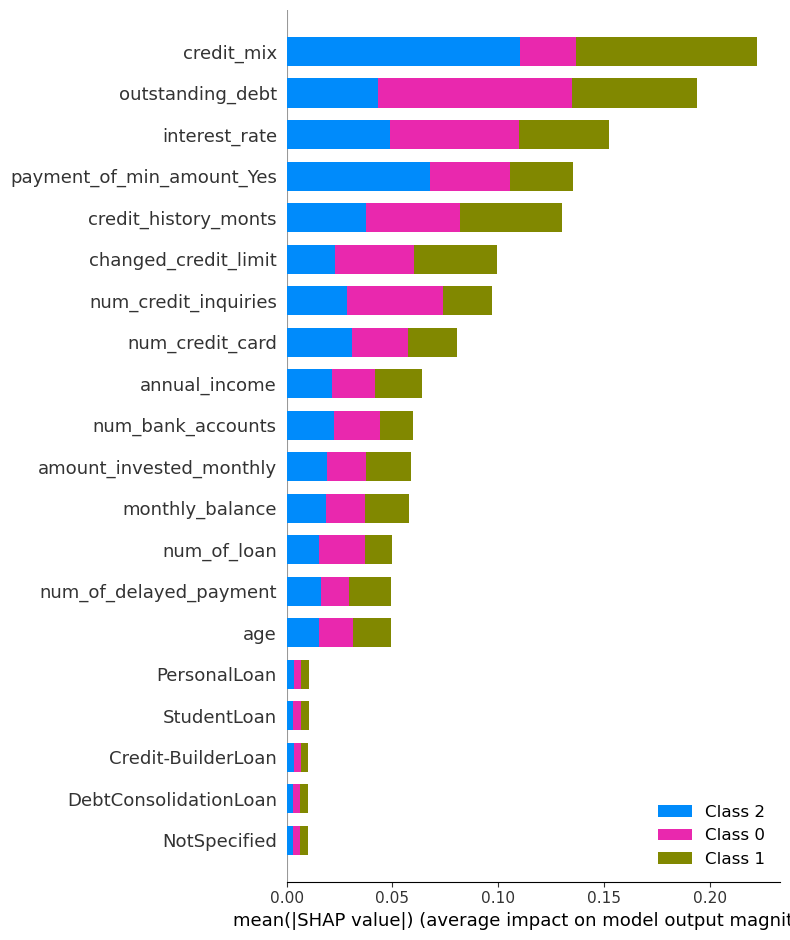

In [6]:
shap.summary_plot(shap_values,X_test_df )

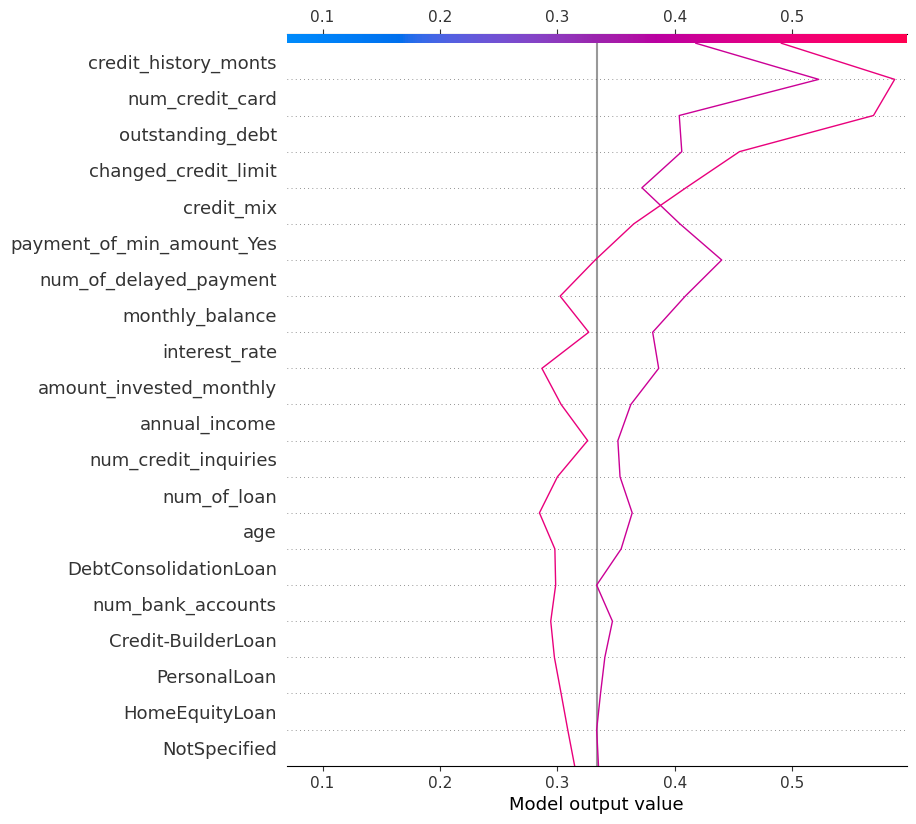

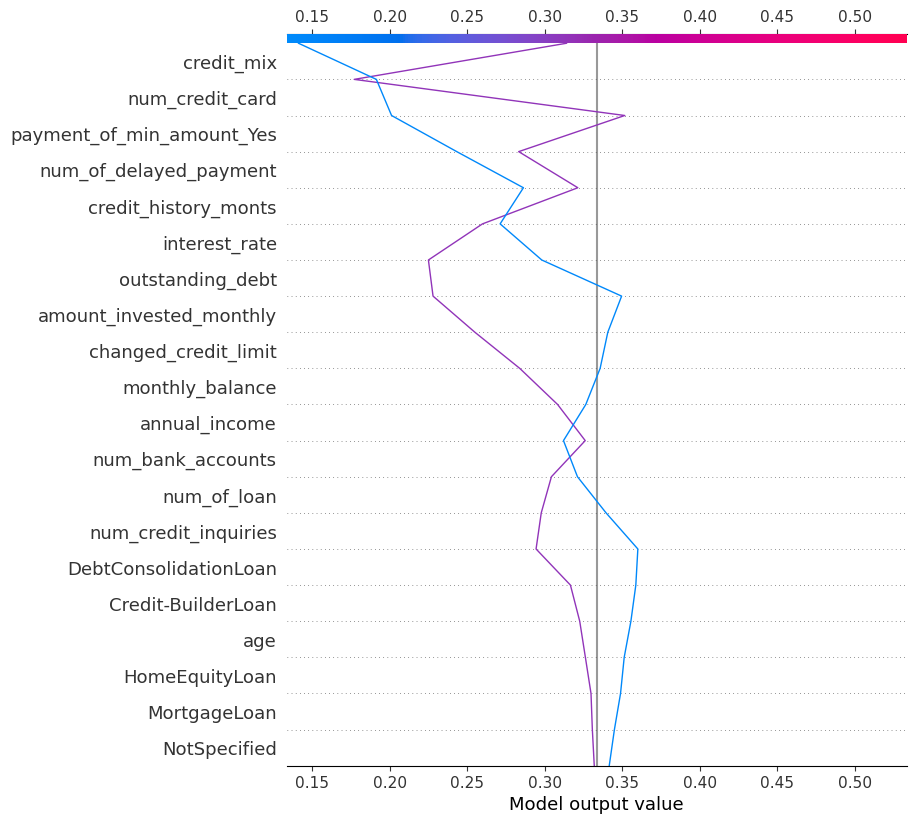

In [7]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
# print(comparison_df.head())
index_A2_P0=comparison_df.loc[(comparison_df['True_Values'] == 2) & (comparison_df['Predicted_Values'] == 0),'Index']
X_A2_P0 = X_test_df.loc[index_A2_P0]
shap_values_A2_P0 = explainer.shap_values(X_A2_P0, approximate=True)
for i in [0,2]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A2_P0[i], X_A2_P0.columns,ignore_warnings=True)

In [1]:
# y_test_reset_index = y_test.reset_index(drop=True)
# Random_Forest_pred_series = pd.Series(Random_Forest_pred)
# Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# # Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
# comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# # Displaying a few rows to check
# index_A0_P2=comparison_df.loc[(comparison_df['True_Values'] == 0) & (comparison_df['Predicted_Values'] == 2),'Index']
# X_A0_P2 = X_test_df.loc[index_A0_P2]
# shap_values_A0_P2 = explainer.shap_values(X_A0_P2, approximate=True)
# for i in [0,2]:
#     shap.decision_plot(explainer.expected_value[1], shap_values_A0_P2[i], X_A0_P2.columns,ignore_warnings=True)

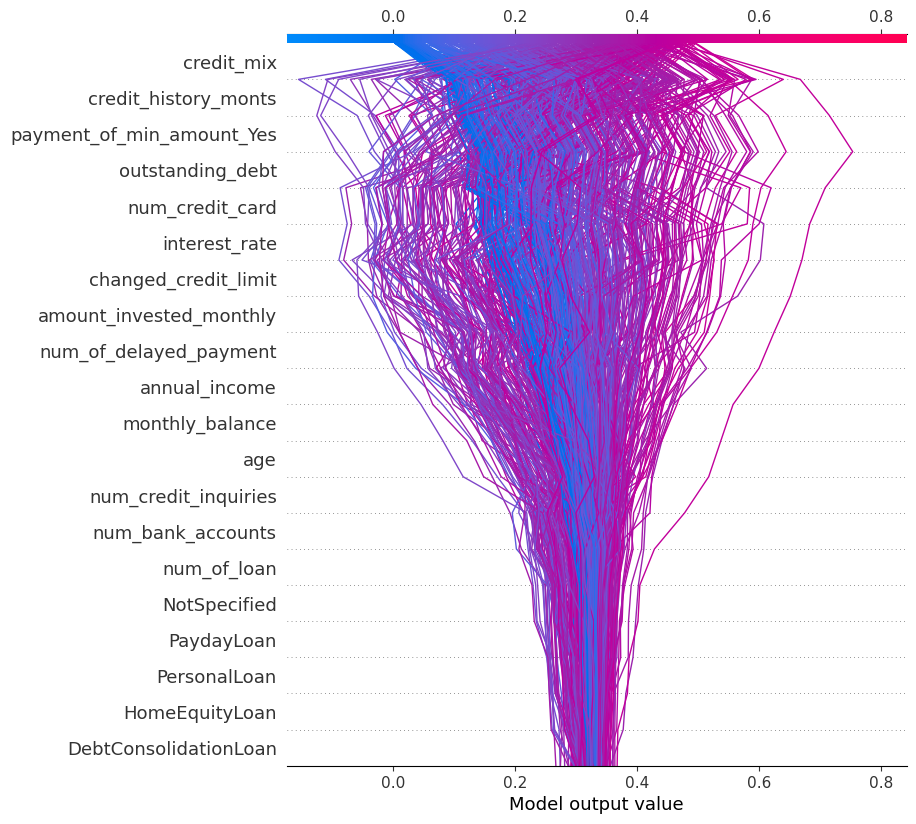

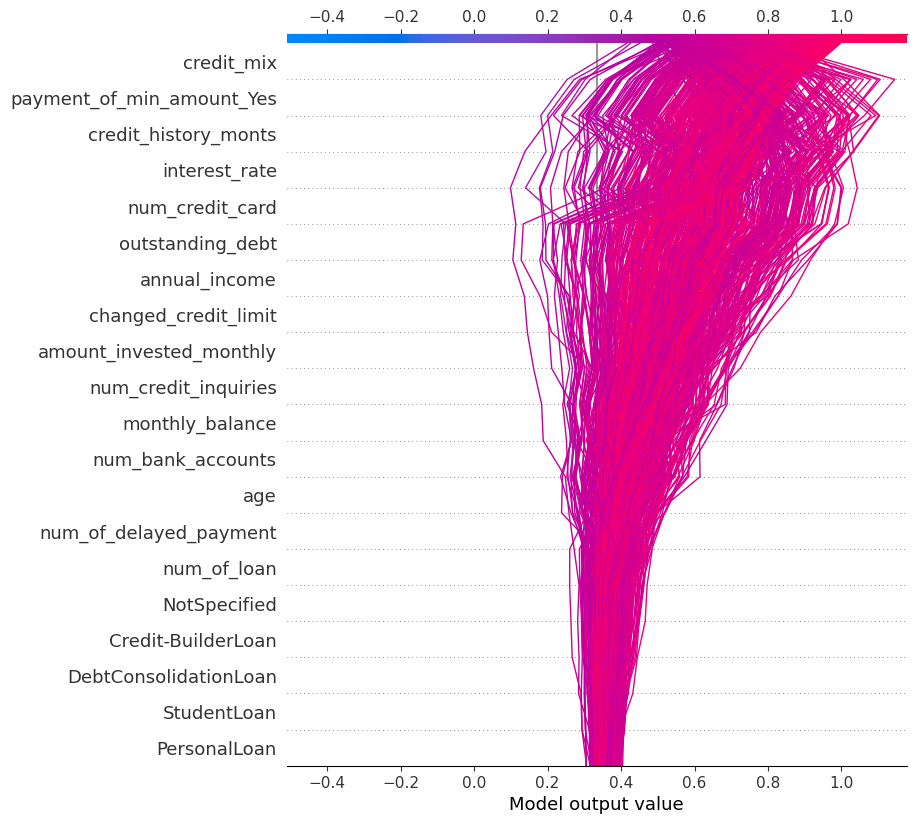

In [8]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A1_P2=comparison_df.loc[(comparison_df['True_Values'] ==1) & (comparison_df['Predicted_Values'] == 2),'Index']
X_A1_P2 = X_test_df.loc[index_A1_P2]
shap_values_A1_P2 = explainer.shap_values(X_A1_P2, approximate=True)
for i in [1,2]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A1_P2[i], X_A1_P2.columns,ignore_warnings=True)

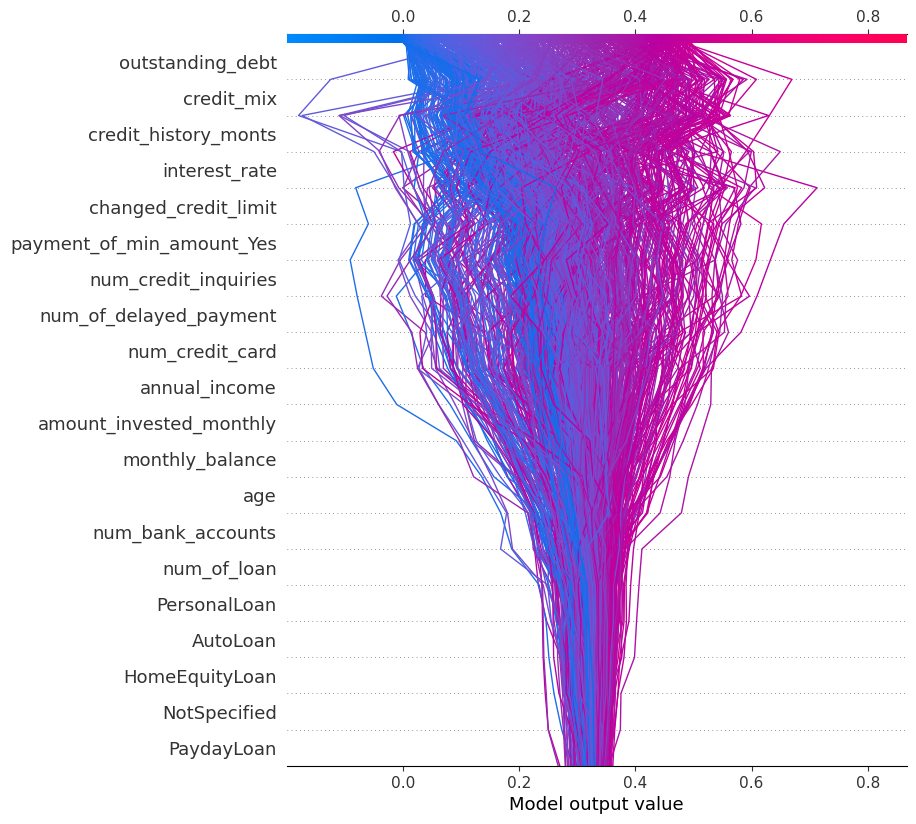

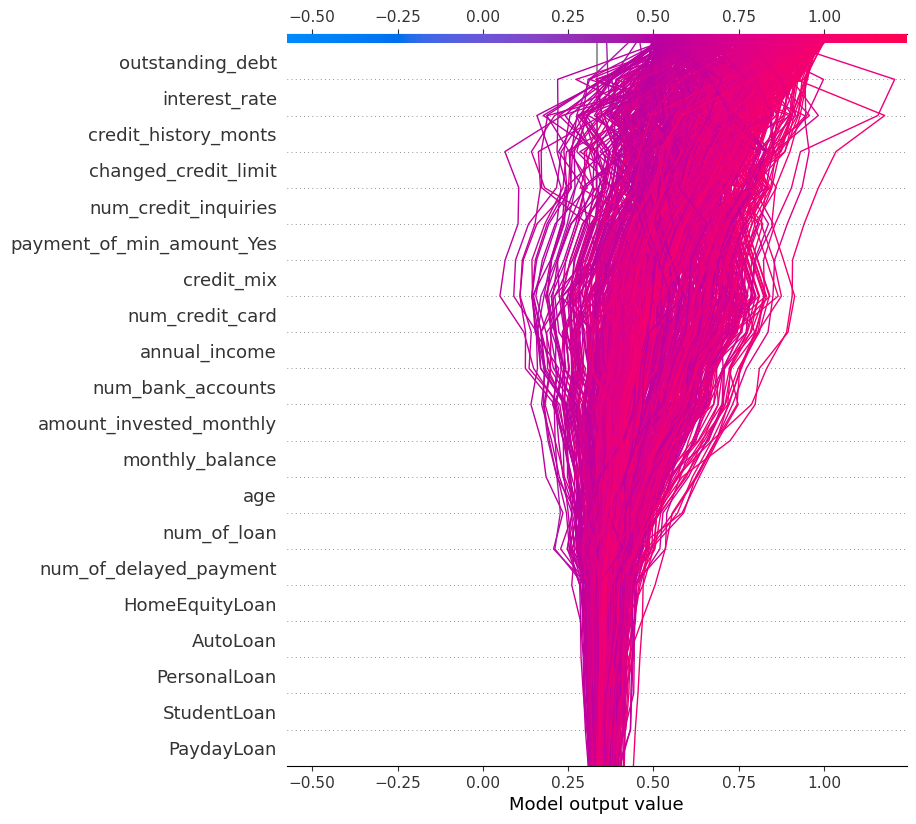

In [9]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A1_P0=comparison_df.loc[(comparison_df['True_Values'] ==1) & (comparison_df['Predicted_Values'] == 0),'Index']
X_A1_P0 = X_test_df.loc[index_A1_P0]
shap_values_A1_P0 = explainer.shap_values(X_A1_P0, approximate=True)
for i in [1,0]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A1_P0[i], X_A1_P0.columns,ignore_warnings=True)

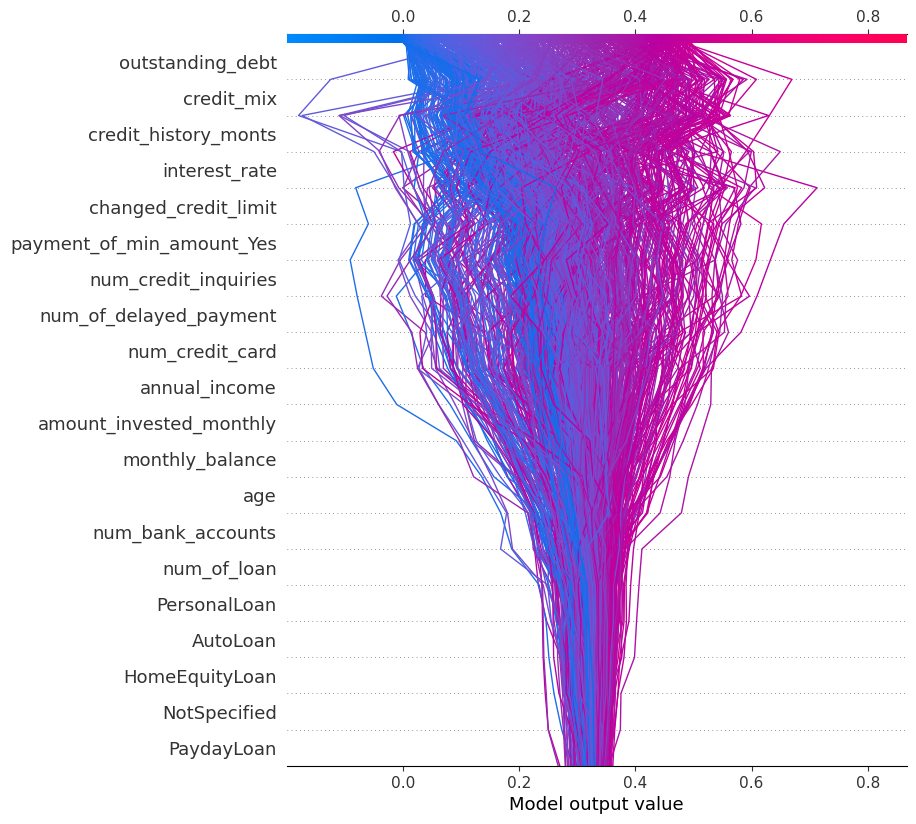

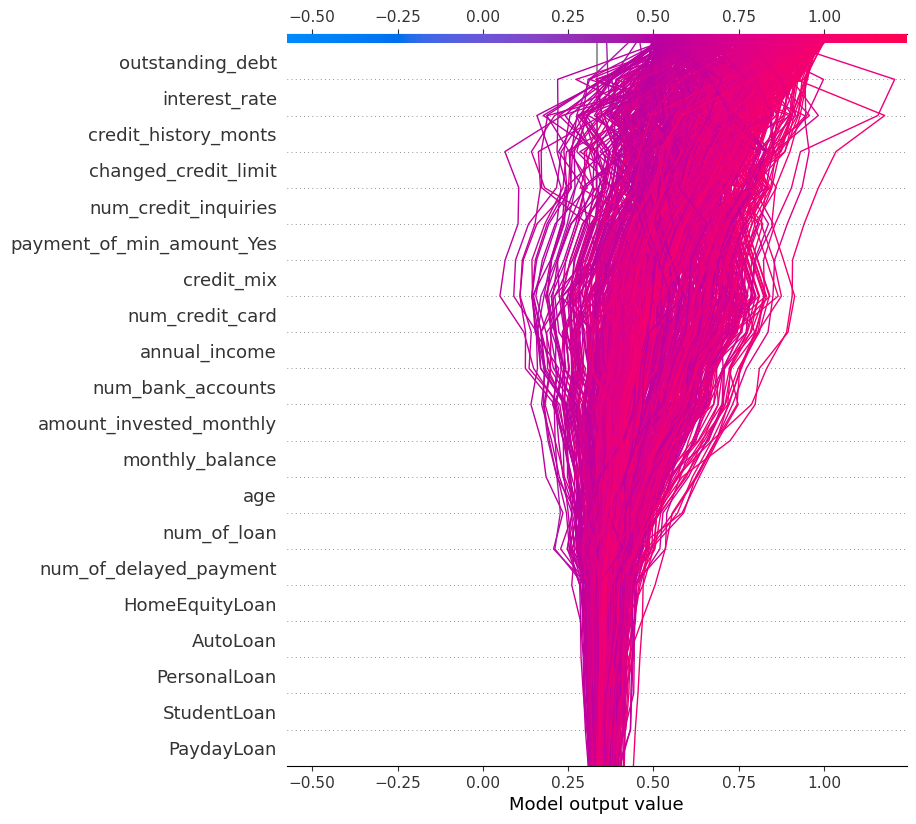

In [10]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A0_P1=comparison_df.loc[(comparison_df['True_Values'] ==0) & (comparison_df['Predicted_Values'] == 1),'Index']
X_A0_P1 = X_test_df.loc[index_A0_P1]
shap_values_A0_P1 = explainer.shap_values(X_A1_P0, approximate=True)
for i in [1,0]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A0_P1[i], X_A0_P1.columns,ignore_warnings=True)